# Enron Scandal: Indentifying Person of Interest

**Identification of Enron employees who may have committed fraud**

**Supervised Learning. Classification**

Data: [Enron financial dataset from Udacity](https://github.com/udacity/ud120-projects/tree/master/final_project)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import keras

helper.info_gpu()
#sns.set_palette("Reds")
helper.reproducible(seed=0)  # setup reproducible results from run to run using Keras

%matplotlib inline

Using TensorFlow backend.


-- No GPU  --
Keras		v2.0.5
TensorFlow	v1.3.0


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = 'data/enron_financial_data.pkl'
target = ['poi']

df = pd.read_pickle(data_path)
df = pd.DataFrame.from_dict(df, orient='index')
print("rows: {} \ncolumns: {} \ntarget: {}".format(*df.shape, target))

rows: 146 
columns: 21 
target: ['poi']


**poi** =  person of interest (boolean) <br>

### Explore the target

In [3]:
print(df[target].squeeze().value_counts(dropna=False))

False    128
True      18
Name: poi, dtype: int64


** Imbalanced target: the evaluation metric used in this problem is the Area Under the ROC Curve **

### Show the data

In [4]:
df.head(3)

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,1729541,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,257817,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,5243487,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN


### Transform the data

In [5]:
# delete 'TOTAL' row (at the bottom)
if 'TOTAL' in df.index:
    df.drop('TOTAL', axis='index', inplace=True)
    
# convert dataframe values (objects) to numerical. There are no categorical features
df = df.apply(pd.to_numeric, errors='coerce')

#### Remove high-missing features

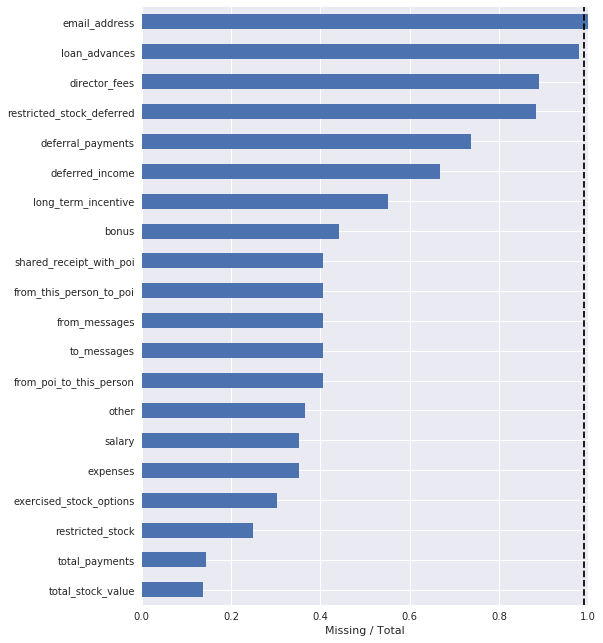

In [6]:
high_missing = helper.missing(df, limit=0.99)

In [7]:
df.drop(high_missing, axis='columns', inplace=True)

#### Classify variables

In [8]:
num = list(df.select_dtypes(include=[np.number]))

df = helper.classify_data(df, target, numerical=num)

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head() # show data types

numerical features:   19
categorical features: 0
target 'poi': category


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
Type,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,category


#### Fill missing values

In [9]:
# Reeplace NaN values with the median
df.fillna(df.median(), inplace=True);
#helper.fill_simple(df, target, inplace=True) # same result

### Visualize the data

In [10]:
df.describe(percentiles=[0.5])

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,1.450000e+02,145.000000,1.450000e+02,145.0,145.00,145.00,1.450000e+02,1.450000e+02,145.00,145.000000,145.000000,145.00,145.000000,1.450000e+02,145.000000,145.000,145.000000,1.450000e+02,145.000000
mean,2.751726e+05,1722.765503,3.836875e+05,2402823.5,2537413.75,1002369.75,-5.090768e+04,-2.939815e+05,3040758.25,51503.250000,52.731033,2455073.25,377.758606,3.142112e+05,27.710344,567548.750,999.072388,9.720599e+05,104361.281250
std,1.428664e+05,2029.355103,7.086024e+05,8785497.0,6606450.50,1097889.50,1.305242e+06,5.750959e+05,6112358.00,37235.035156,68.431458,4646612.00,1441.885376,1.122664e+06,78.611641,597613.875,930.455933,1.972272e+06,14229.056641
min,4.770000e+02,57.000000,-1.025000e+05,148.0,400000.00,70000.00,-1.787380e+06,-3.504386e+06,-44093.00,148.000000,0.000000,3285.00,12.000000,2.000000e+00,0.000000,69223.000,2.000000,-2.604490e+06,3285.000000
50%,2.587410e+05,1211.000000,2.210635e+05,1100246.5,2000000.00,750000.00,-1.402640e+05,-1.519270e+05,1095040.00,46547.500000,35.000000,1297049.00,41.000000,5.198450e+04,8.000000,422158.000,740.500000,4.410960e+05,106164.500000
max,1.111258e+06,15149.000000,6.426990e+06,103559792.0,81525000.00,8000000.00,1.545629e+07,-8.330000e+02,49110080.00,228763.000000,528.000000,34348384.00,14368.000000,1.035973e+07,609.000000,5145434.000,5521.000000,1.476169e+07,137864.000000


#### Numerical features

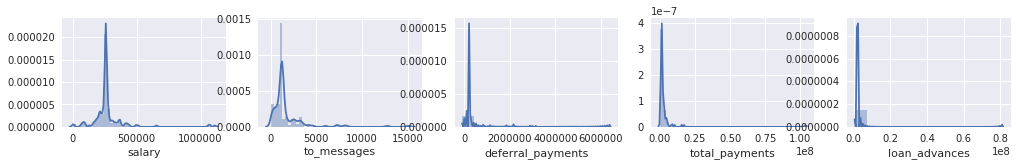

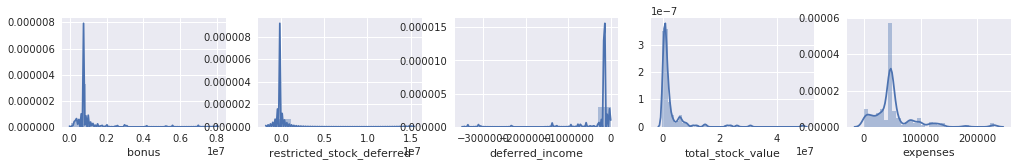

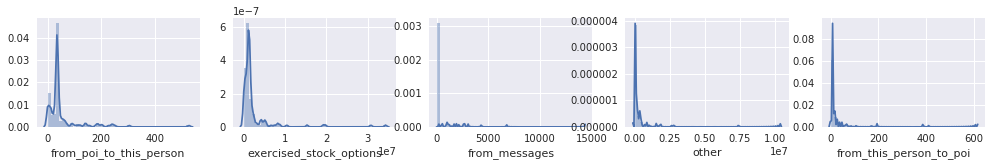

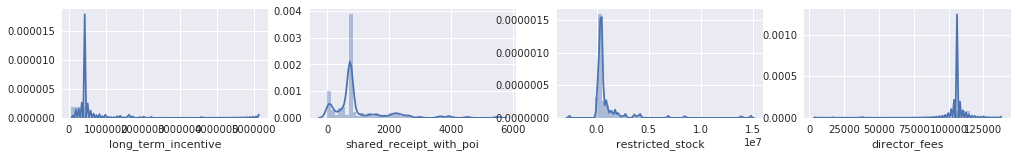

In [11]:
helper.show_numerical(df.iloc[:,:5], kde=True)
helper.show_numerical(df.iloc[:,5:10], kde=True)
helper.show_numerical(df.iloc[:,10:15], kde=True)
helper.show_numerical(df.iloc[:,15:], kde=True)

#### Target vs Numerical features

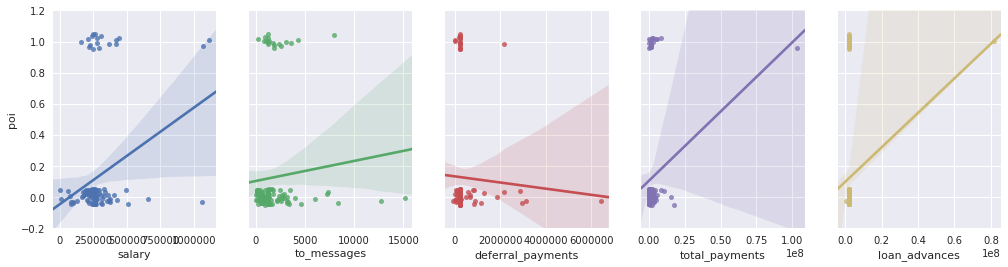

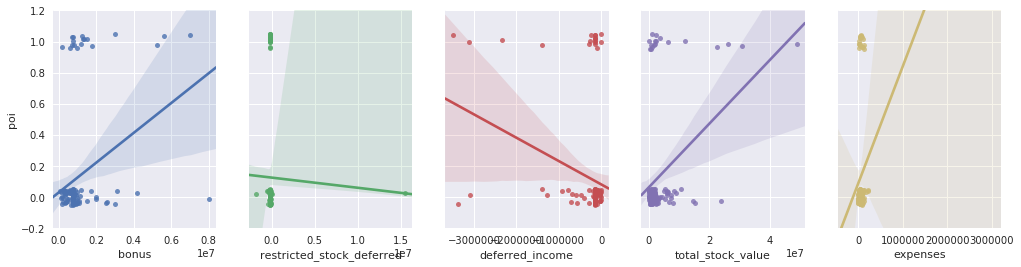

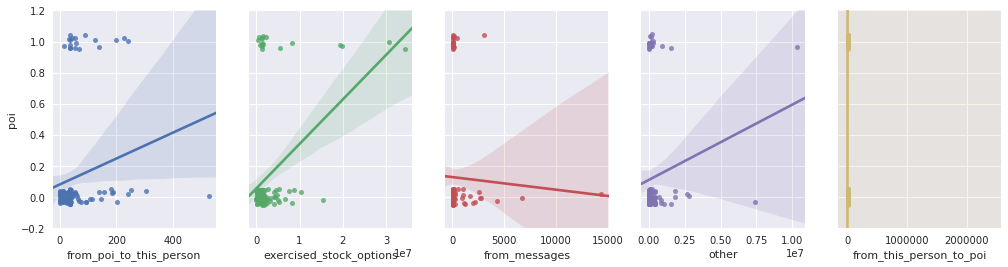

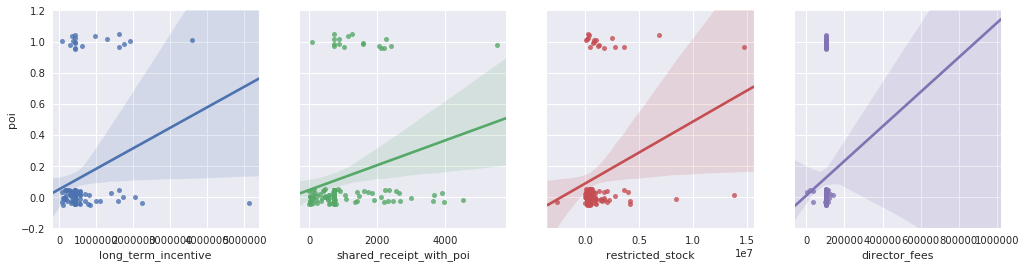

In [12]:
helper.show_target_vs_numerical(df.iloc[:,:5].join(df[target]), target, jitter=0.05, fit_reg=True, point_size=100)
plt.ylim(ymin=-0.2, ymax=1.2);
helper.show_target_vs_numerical(df.iloc[:,5:10].join(df[target]), target, jitter=0.05, fit_reg=True, point_size=100)
plt.ylim(ymin=-0.2, ymax=1.2);
helper.show_target_vs_numerical(df.iloc[:,10:15].join(df[target]), target, jitter=0.05, fit_reg=True, point_size=100)
plt.ylim(ymin=-0.2, ymax=1.2);
helper.show_target_vs_numerical(df.iloc[:,15:], target, jitter=0.05, fit_reg=True, point_size=100)
plt.ylim(ymin=-0.2, ymax=1.2);

#### Total stock value vs some features 

(0, 50000000.0)

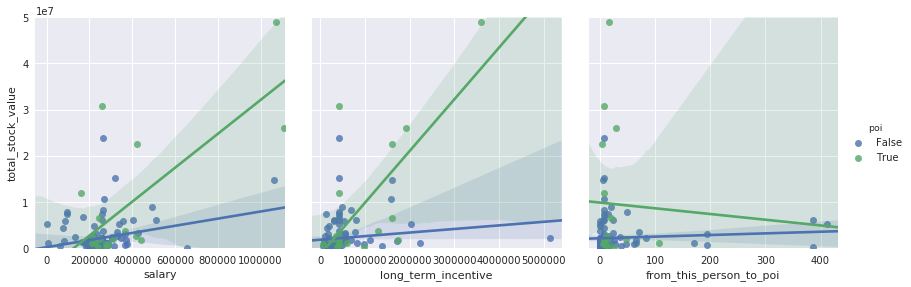

In [13]:
# df.plot.scatter(x='salary', y='total_stock_value')
# df.plot.scatter(x='long_term_incentive', y='total_stock_value')

# sns.lmplot(x="salary", y="total_stock_value", hue='poi', data=df)
# sns.lmplot(x="long_term_incentive", y="total_stock_value", hue='poi', data=df)

g = sns.PairGrid(
    df,
    y_vars=["total_stock_value"],
    x_vars=["salary", "long_term_incentive", "from_this_person_to_poi"],
    hue='poi',
    size=4)
g.map(sns.regplot).add_legend()
plt.ylim(ymin=0, ymax=0.5e8)

#sns.pairplot(df, hue='poi', vars=['long_term_incentive', 'total_stock_value', 'from_poi_to_this_person'], kind='reg', size=3)

The person of interest seems to have a higher stock vs salary and long-term incentive, especially when his stock value is high. There is no dependency between POI and the amount of emails from or to another person of interest.

#### Correlation between numerical features and target

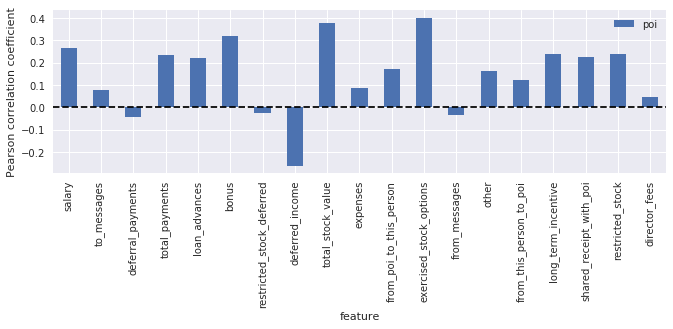

In [14]:
helper.show_correlation(df, target, figsize=(11,3))

## 2. Neural Network model

### Tune selected features
Fast way to remove features before training the model


In [15]:
fields_to_drop = []
data = df.drop(fields_to_drop, axis=1)
# filtered dataset now in 'data'

### Scale numerical features

In [16]:
# here all the features except for target 'poi' are continuous variable
quant_features = list(data.drop(target, axis=1))

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in quant_features:
    mean, std = data[f].mean(), data[f].std()
    scaled_features[f] = [mean, std]
    data.loc[:, f] = (data[f] - mean) / std

data.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
ALLEN PHILLIP K,-0.512490,0.581088,3.508356,0.236938,-0.081347,2.889754,-0.057552,-4.846276,-0.214519,-1.010748,-0.083749,-0.156142,1.260323,-0.279745,0.474353,-0.439655,0.438417,-0.428964,0.126728,False
BADUM JAMES P,-0.115013,-0.252181,-0.288889,-0.252730,-0.081347,-0.229868,-0.068460,0.247010,-0.455297,-1.289572,-0.259106,-0.472873,-0.233554,-0.233575,-0.250731,-0.243285,-0.277899,-0.269214,0.126728,False
BANNANTINE JAMES M,-1.922745,-0.570016,-0.229500,-0.169214,-0.081347,-0.229868,-0.390207,0.502312,0.360373,0.128850,-0.200654,0.342418,-0.241877,0.490184,-0.352497,-0.243285,-0.573990,0.398268,0.126728,False
BAXTER JOHN C,-0.056490,-0.252181,1.287112,0.367824,-0.081347,0.180009,-0.068460,-1.898942,1.240520,-1.082401,-0.259106,0.909366,-0.233554,2.089754,-0.250731,1.704288,-0.277899,1.506209,0.126728,False
BAY FRANKLIN R,-0.248495,-0.252181,-0.173909,-0.179287,-0.081347,-0.548662,-0.024420,0.160565,-0.487168,2.085099,-0.259106,-0.249219,-0.233554,-0.279819,-0.250731,-0.243285,-0.277899,-0.418940,0.126728,False


### Split the data into training and test sets

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.4, random_state=9, stratify=df[target])

# Separate the data into features and targets (x=features, y=targets)
x_train, y_train_nc = train.drop(target, axis=1).values, train[target].values
x_test, y_test_nc = test.drop(target, axis=1).values, test[target].values
# _nc: non-categorical yet

# no validation set; categorical_crossentropy will be used here

### Encode the output

In [18]:
import keras

# One-hot encoding the output
num_classes = 2
y_train = keras.utils.to_categorical(y_train_nc, num_classes)
y_test = keras.utils.to_categorical(y_test_nc, num_classes)
print("Training set: \t x-shape = {} \t y-shape = {}".format(x_train.shape, y_train.shape))
print("Test set: \t x-shape = {} \t y-shape = {}".format(x_test.shape, y_test.shape))

Training set: 	 x-shape = (87, 19) 	 y-shape = (87, 2)
Test set: 	 x-shape = (58, 19) 	 y-shape = (58, 2)


### Dummy classifier

In [19]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc


def scores(y_test, y_pred):
    """ Print  different scores """

    print()
    print('Accuracy: \t{:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: \t{:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: \t{:.2f}'.format(recall_score(y_test, y_pred)))
    print('\n Confusion matrix: \n', confusion_matrix(y_test, y_pred))

In [20]:
from sklearn.dummy import DummyClassifier

# Negative class (0) is most frequent
%time clf = DummyClassifier(strategy='most_frequent').fit(x_train, np.ravel(y_train))
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_pred = clf.predict(x_test).reshape([-1, 1])

scores(y_test[:, 1], y_pred)
print('\n\n ROC AUC test: \t{:.2f} \n'.format(roc_auc_score(y_test[:, 1], y_pred)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 477 µs

Accuracy: 	0.88
Precision: 	0.00
Recall: 	0.00

 Confusion matrix: 
 [[51  0]
 [ 7  0]]


 ROC AUC test: 	0.50 



/home/angel/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Neural Network
  

In [21]:
from sklearn.utils import class_weight

y_plain = np.ravel(y_train[:,1])

cw = class_weight.compute_class_weight('balanced', np.unique(y_plain), y_plain)

cw = {idx : value for idx, value in enumerate(cw)}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 19)                380       
_________________________________________________________________
dropout_1 (Dropout)          (None, 19)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________


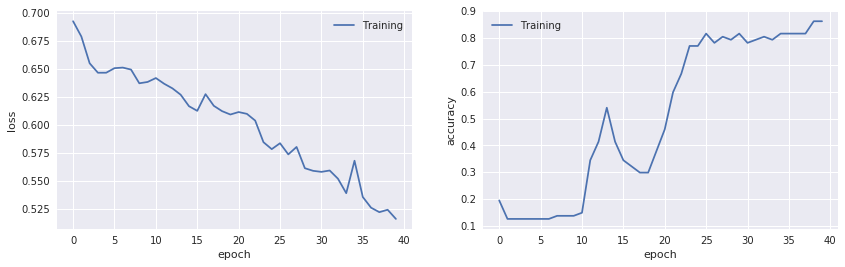


Training loss:  	0.5164

Training accuracy: 	0.862

ROC_AUC train:	0.89 



In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras import regularizers

nodes = x_train.shape[1]

weights = keras.initializers.RandomNormal(stddev=0.00001)

model = Sequential()
model.add(
    Dense(
        nodes,
        input_dim=x_train.shape[1],
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        kernel_initializer=weights,
        bias_initializer='zero'))
model.add(Dropout(0.1))
model.add(
    Dense(
        2,
        activation='softmax',
        kernel_initializer=weights,
        kernel_regularizer=regularizers.l2(0.01),
        bias_initializer='zero'))

opt = keras.optimizers.adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, epochs=40, batch_size=256, verbose=0, class_weight=cw)

helper.show_training(history)

y_pred_train = model.predict(x_train, verbose=0)
print('\nROC_AUC train:\t{:.2f} \n'.format(roc_auc_score(y_train, y_pred_train)))


### Evaluate the model

In [23]:
# Dataset too small for train, validation, and test sets. More data is needed for a proper
#   model validation

score = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy test: {:.4f}".format(score[1]))

y_pred = model.predict(x_test, verbose=0)[:, 1]
print('\nNeural Network ROC AUC test: \t{:.2f} \n'.format(roc_auc_score(y_test[:, 1], y_pred)))
scores(y_test[:, 1], (y_pred > 0.5).astype(int))

Accuracy test: 0.7931

Neural Network ROC AUC test: 	0.66 


Accuracy: 	0.79
Precision: 	0.27
Recall: 	0.43

 Confusion matrix: 
 [[43  8]
 [ 4  3]]
